# Quantum Walks

A framework of quantum algorithm which is originated from classical random walks.

This notebook is created for the discrete-time quantum walks based on 16 nodes.

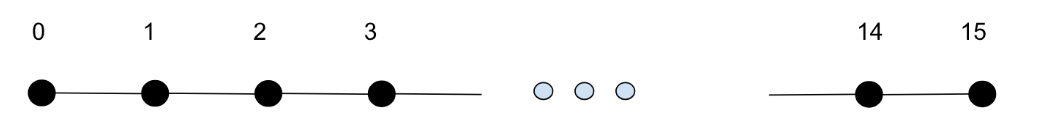

Firsly, prepare the size = 4 for 16 nodes

In [1]:
from classiq import *

size = 4

Prepare zero-diffuzer operator for Phase-kickback

In [2]:
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

Prepare C_iteration for superposition of adjacent vertices in connection with target vertice.


We need to initialize the probability for 16 nodes.
Base on the above picture, there isn't any connection between 0 and 15. 0 only connects with 1 and 15 only connects with 14.
Therefore, if i == 0, p[1] = 1 and if i == 15, p[14] = 1.

for other nodes, moving forward   p[(i+1)% (2**size)] = 0.5,

                 moving backward p[(i-1)% (2**size)] = 0.5

Unitary is in the inplace_prepare_state

In [3]:
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    # intialize the probability for 16 nodes 
    prob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if i == 0: #  0 is only connected with 1
        prob[1] = 1
    elif i == 15: # 15 is only connected with 14
        prob[14] = 1
    else:# others are in equal superposition
        prob[(i+1)% 16]=0.5
        prob[(i-1)% 16]=0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


Create the C_operator to iterate over all the vertices we have

In [4]:
@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        C_iteration(i,vertices,adjacent_vertices)

Prepare edge_oracle

res(edge) wil be one only when there is a connection between vertices.

For this case, if (veritces - adjacent_vertices) == 1 or -1, an edge can be found between two vertices.

In [5]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1)) 

For S_operator, we create bitwise_swap first.

In [6]:
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))

Create S_operator using edge_oracle and bitwise_swap to have a swap only if there is an edge between two vertices.

If not, don't apply bitwise_swap.

In [7]:
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
    operand= lambda: bitwise_swap(vertices,adjacent_vertices))

Now we have both C and S operators to implement the main operator.

In [10]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    allocate(size,vertices)
    hadamard_transform(vertices)
    allocate(size,adjacent_vertices)

    C_operator(vertices,adjacent_vertices)
    S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 